# Residual Connections

If your function chain is too
deep, this noise starts overwhelming gradient information, and backpropagation
stops working. Your model won’t train at all. This is the vanishing gradients problem.
 The fix is simple: just force each function in the chain to be nondestructive—to
retain a noiseless version of the information contained in the previous input. The easiest way to implement this is to use a residual connection. It’s dead easy: just add the
input of a layer or block of layers back to its output

The residual connection acts as an information shortcut around destructive or noisy blocks (such as
blocks that contain relu activations or dropout layers), enabling error gradient information from early layers to propagate noiselessly through a deep network

Note that adding the input back to the output of a block implies that the output
should have the same shape as the input. However, this is not the case if your block
includes convolutional layers with an increased number of filters, or a max pooling
layer. In such cases, use a 1 × 1 Conv2D layer with no activation to linearly project the
residual to the desired output shape

You’d typically use padding=
"same" in the convolution layers in your target block so as to avoid spatial downsampling due to padding, and you’d use strides in the residual projection to match any
downsampling caused by a max pooling layer

In [ ]:
# Residual block where the number of filters changes

from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)

# Set aside the residual.
residual = x

# This is the layer around which we create a residual connection: it increases the number of output filers from 32 to 64. Note that we use padding="same" to avoid downsampling due to padding.
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)

# The residual only had 32 filters, so we use a 1 × 1 Conv2D to project it to the correct shape.
residual = layers.Conv2D(64, 1)(residual)

# Now the block output and the residual have the same shape and can be added
x = layers.add([x, residual])

In [ ]:
#  Case where the target block includes a max pooling layer

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x

# This is the block of two layers around which we create a residual connection: it includes a 2 × 2 max pooling layer. Note that we use padding="same" in both the convolution layer and the max pooling layer to avoid
# downsampling due to padding.
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)

# We use strides=2 in the residual projection to match the downsampling created by the max pooling layer
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

To make these ideas more concrete, here’s an example of a simple convnet structured
into a series of blocks, each made of two convolution layers and one optional max
pooling layer, with a residual connection around each block

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)
def residual_block(x, filters, pooling=False):
 residual = x
 x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
 if pooling:
  # If we use max pooling, we add a strided convolution to project the residual to the expected shape.
  x = layers.MaxPooling2D(2, padding="same")(x)
  residual = layers.Conv2D(filters, 1, strides=2)(residual)
 elif filters != residual.shape[-1]:
  # If we don’t use max pooling, we only project the residual if the number of channels has changed.
  residual = layers.Conv2D(filters, 1)(residual)
 x = layers.add([x, residual])
 return x

In [ ]:
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False) # The last block doesn’t need a max pooling layer, since we will apply global average pooling right after it.
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 32)           896       ['rescaling[0][0]']           
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 32)           9248      ['conv2d_6[0][0]']            
                                                                                              

With residual connections, you can build networks of arbitrary depth, without having
to worry about vanishing gradients.

# Batch Normalization

Batch normalization does just that. It’s a type of layer (BatchNormalization in
Keras) introduced in 2015 by Ioffe and Szegedy;2
 it can adaptively normalize data even
as the mean and variance change over time during training. During training, it uses
the mean and variance of the current batch of data to normalize samples, and during
inference (when a big enough batch of representative data may not be available), it
uses an exponential moving average of the batch-wise mean and variance of the data
seen during training.

 In practice, the main effect of batch normalization appears to be that it helps with
gradient propagation—much like residual connections—and thus allows for deeper
networks. Some very deep networks can only be trained if they include multiple
BatchNormalization layers. For instance, batch normalization is used liberally in
many of the advanced convnet architectures that come packaged with Keras, such as
ResNet50, EfficientNet, and Xception.
 The BatchNormalization layer can be used after any layer—Dense, Conv2D, etc

Both Dense and Conv2D involve a bias vector, a learned variable whose
purpose is to make the layer affine rather than purely linear. For instance,
Conv2D returns, schematically, y = conv(x, kernel) + bias, and Dense returns
y = dot(x, kernel) + bias. Because the normalization step will take care of
centering the layer’s output on zero, the bias vector is no longer needed
when using BatchNormalization, and the layer can be created without it via
the option use_bias=False. This makes the layer slightly leaner.


Importantly, I would generally recommend placing the previous layer’s activation after
the batch normalization layer

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

The intuitive reason for this approach is that batch normalization will center your
inputs on zero, while your relu activation uses zero as a pivot for keeping or dropping
activated channels: doing normalization before the activation maximizes the utilization of the relu. That said, this ordering best practice is not exactly critical, so if you
do convolution, then activation, and then batch normalization, your model will still
train, and you won’t necessarily see worse results.

when fine-tuning a model that includes BatchNormalization layers, I recommend
leaving these layers frozen (set their trainable attribute to False). Otherwise they
will keep updating their internal mean and variance, which can interfere with the very
small updates applied to the surrounding Conv2D layers.

# Depthwise Seperable Convolutions

What if I told you that there’s a layer you can use as a drop-in replacement for Conv2D
that will make your model smaller (fewer trainable weight parameters) and leaner
(fewer floating-point operations) and cause it to perform a few percentage points better on its task? That is precisely what the depthwise separable convolution layer does (SeparableConv2D in Keras). This layer performs a spatial convolution on each channel of
its input, independently, before mixing output channels via a pointwise convolution
(a 1 × 1 convolution)

This is equivalent to separating the learning of spatial features and the learning of
channel-wise features. In much the same way that convolution relies on the assumption that the patterns in images are not tied to specific locations, depthwise separable
convolution relies on the assumption that spatial locations in intermediate activations
are highly correlated, but different channels are highly independent. Because this assumption
is generally true for the image representations learned by deep neural networks, it
serves as a useful prior that helps the model make more efficient use of its training
data. A model with stronger priors about the structure of the information it will have
to process is a better model—as long as the priors are accurate

Depthwise separable convolution requires significantly fewer parameters and
involves fewer computations compared to regular convolution, while having comparable representational power. It results in smaller models that converge faster and are
less prone to overfitting. These advantages become especially important when you’re
training small models from scratch on limited data.

[Depthwise Parameter Calculation](https://chat.openai.com/share/add06a60-e4b4-45dd-adb5-f4c7b7730950)

 here are the convnet architecture principles you’ve learned so far:

 Your model should be organized into repeated blocks of layers, usually made of
multiple convolution layers and a max pooling layer.

 The number of filters in your layers should increase as the size of the spatial feature maps decreases.

 Deep and narrow is better than broad and shallow.

 Introducing residual connections around blocks of layers helps you train
deeper networks.

 It can be beneficial to introduce batch normalization layers after your convolution layers.

 It can be beneficial to replace Conv2D layers with SeparableConv2D layers,
which are more parameter-efficient.

Let’s bring these ideas together into a single model. Its architecture will resemble a
smaller version of Xception, and we’ll apply it to the dogs vs. cats task

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:05<00:00, 136MB/s]
100% 812M/812M [00:05<00:00, 151MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
train_zip_path = '/content/train.zip'
test_zip_path = '/content/test1.zip'

# Specify the extraction paths
train_extract_path = '/content/dogs-vs-cats/train'
test_extract_path = '/content/dogs-vs-cats/test'

# Create extraction directories if they do not exist
!mkdir -p {train_extract_path}
!mkdir -p {test_extract_path}

# Unzip the train and test files
!unzip -qq {train_zip_path} -d {train_extract_path}
!unzip -qq {test_zip_path} -d {test_extract_path}

In [ ]:
from pathlib import Path
import os
import shutil

def make_subset(subset_name, start_index, end_index):
    new_base_dir = Path('/content/cats_vs_dogs_small')
    original_dir = Path('/content/dogs-vs-cats/train/train')

    for category in ("cat", "dog"):
        dir_path = new_base_dir / subset_name / category
        os.makedirs(dir_path, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
            src_path = original_dir / fname
            dst_path = dir_path / fname
            shutil.copyfile(src=src_path, dst=dst_path)

# Example usage:
make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)


In [ ]:
import os, shutil, pathlib
new_base_dir = pathlib.Path("cats_vs_dogs_small")
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory( new_base_dir / "train", image_size=(180, 180),batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",image_size=(180, 180),batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test",image_size=(180, 180),batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
 print("data batch shape:", data_batch.shape)
 print("labels batch shape:", labels_batch.shape)
 break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Define a data augmentation stage to add to an image model
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

"""
Note that the assumption that underlies
separable convolution, “feature channels are
largely independent,” does not hold for RGB
images! Red, green, and blue color channels
are actually highly correlated in natural
images. As such, the first layer in our model
is a regular Conv2D layer. We’ll start using
SeparableConv2D afterwards.
"""

x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
for size in [32, 64, 128, 256, 512]:
  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [ ]:
history = model.fit(
 train_dataset,
 epochs=100,
 validation_data=validation_dataset)

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 45ms/step - loss: 0.4254 - accuracy: 0.8555
Test accuracy: 0.855


#  Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the values returned by various
convolution and pooling layers in a model, given a certain input (the output of a layer is
often called its activation, the output of the activation function). This gives a view into
how an input is decomposed into the different filters learned by the network.

We want
to visualize feature maps with three dimensions: width, height, and depth (channels).
Each channel encodes relatively independent features, so the proper way to visualize
these feature maps is by independently plotting the contents of every channel as a 2D
image

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Next, we’ll get an input image—a picture of a cat, not part of the images the network
was trained on

In [ ]:
from tensorflow import keras
import numpy as np
img_path = keras.utils.get_file(
 fname="cat.jpg",
 origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(
  img_path, target_size=target_size)
  array = keras.utils.img_to_array(img) # Turn the image into a float32 NumPy array of shape (180, 180, 3).
  array = np.expand_dims(array, axis=0)  # Add a dimension to transform the array into a “batch” of a single sample. Its shape is now (1, 180, 180, 3).
  return array
img_tensor = get_img_array(img_path, target_size=(180, 180))


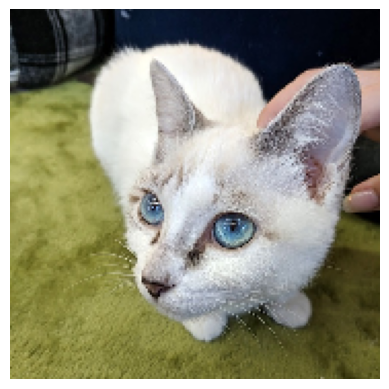

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In order to extract the feature maps we want to look at, we’ll create a Keras model that
takes batches of images as input, and that outputs the activations of all convolution
and pooling layers

In [ ]:
from tensorflow.keras import layers
layer_outputs = []
layer_names = []
for layer in model.layers:
  # Extract the outputs of all Conv2D and MaxPooling2D layers and put them in a list.
 if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)

# Create a model that will return these outputs, given the model input.
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the
original model, as a list. This is the first time you’ve encountered a multi-output
model in this book in practice.

This one has one
input and nine outputs: one output per layer activation.

In [ ]:
activations = activation_model.predict(img_tensor)
# Return a list of nine NumPy arrays: one array per layer activation.

In [ ]:
 first_layer_activation = activations[0]

In [ ]:
print(first_layer_activation.shape)

(1, 176, 176, 32)


It’s a 176 × 176 feature map with 32 channels. Let’s try plotting the fifth channel of the
activation of the first layer of the original model

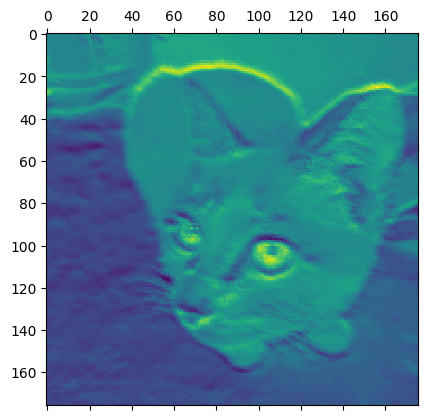

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

This channel appears to encode a diagonal edge detector—but note that your own
channels may vary, because the specific filters learned by convolution layers aren’t
deterministic.


In the context of a deep learning model, when we say a channel "encodes" a diagonal edge detector, we are referring to the role or function of that particular channel in the convolutional neural network (CNN). Let's break down the key terms:

**Channel**: In deep learning, particularly in CNNs, a channel refers to a set of filters that are applied to the input data. Each filter detects specific features in the input, and the set of filters together form a channel.

**Encodes**: In this context, "encodes" means that the filters in the channel have learned to respond strongly to a particular type of pattern or feature in the input data. In other words, the channel has learned a representation that is useful for identifying a specific characteristic in the input.

**Diagonal Edge Detector**: This refers to a filter that is specifically designed to detect diagonal edges in an image. An edge detector filter highlights the boundaries or edges between different regions in an image, and a diagonal edge detector focuses on diagonal edges.

Now, when the text mentions that a channel "encodes a diagonal edge detector," it means that the set of filters in that channel has learned to recognize and highlight diagonal edges in the input data. The filters in this channel are responsive to diagonal patterns, and when applied to an input image, they produce a strong response where diagonal edges are present.

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 31], cmap="viridis")

Now, let’s plot a complete visualization of all the activations in the network.

We’ll extract and plot every channel in each of the layer activations, and
we’ll stack the results in one big grid, with channels stacked side by side.

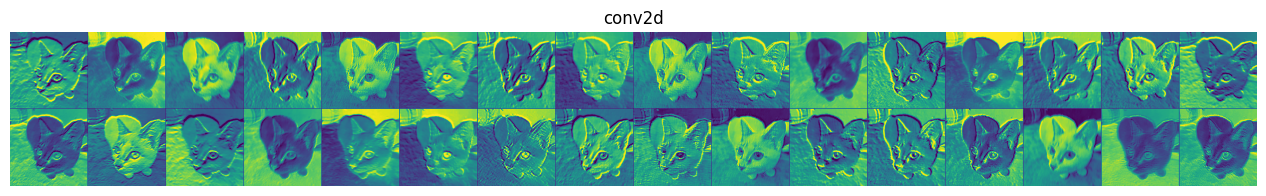

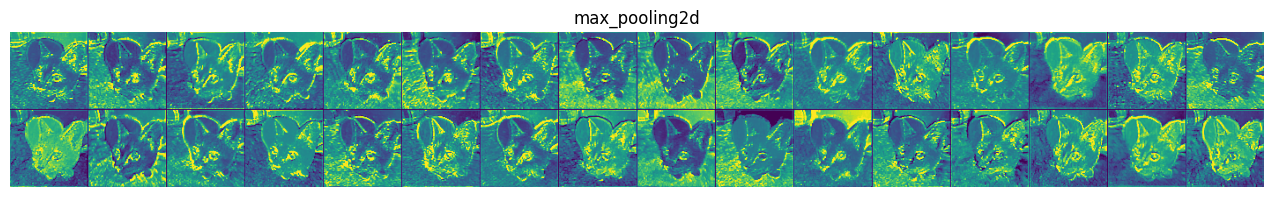

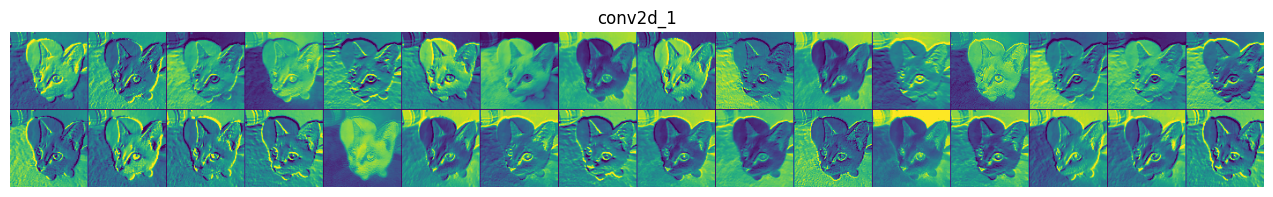

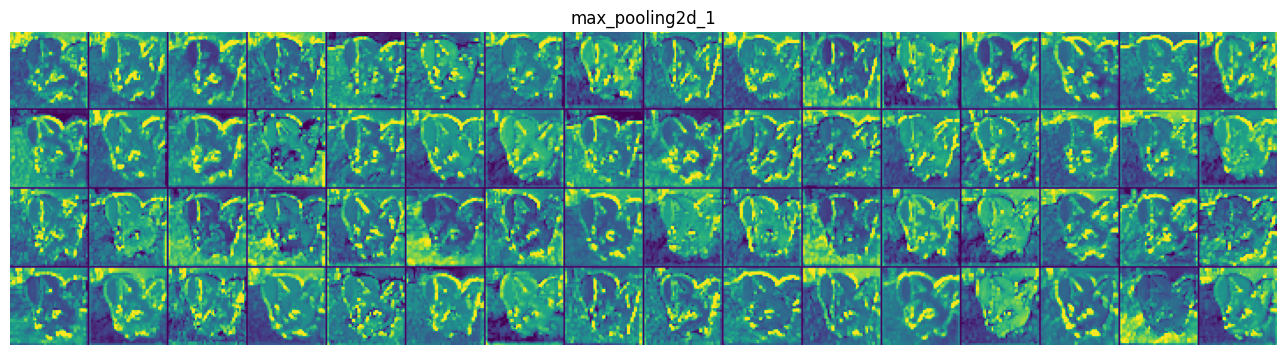

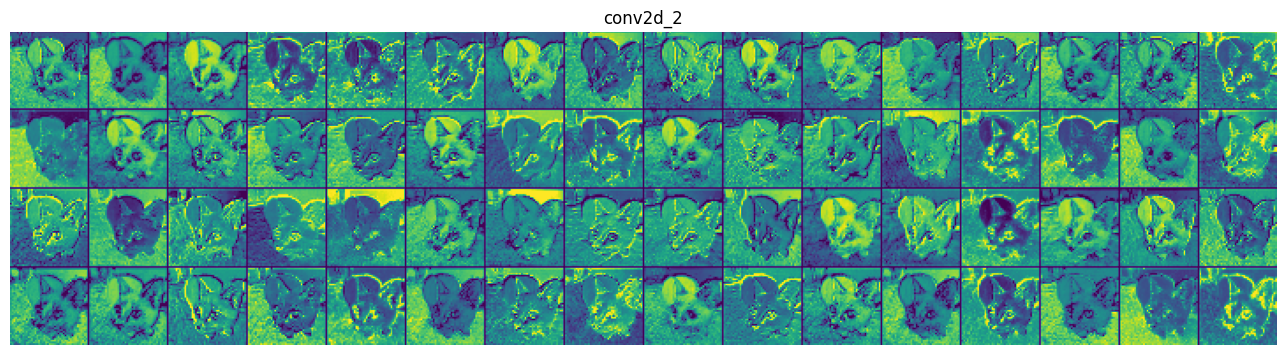

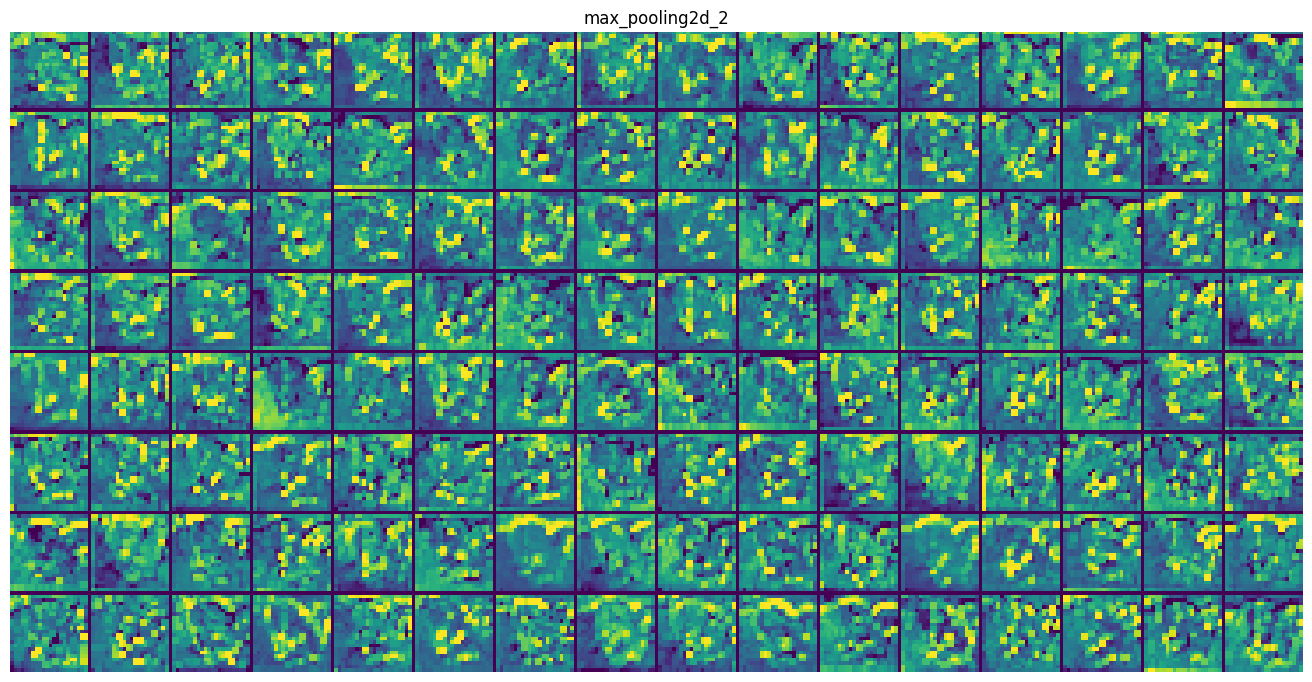

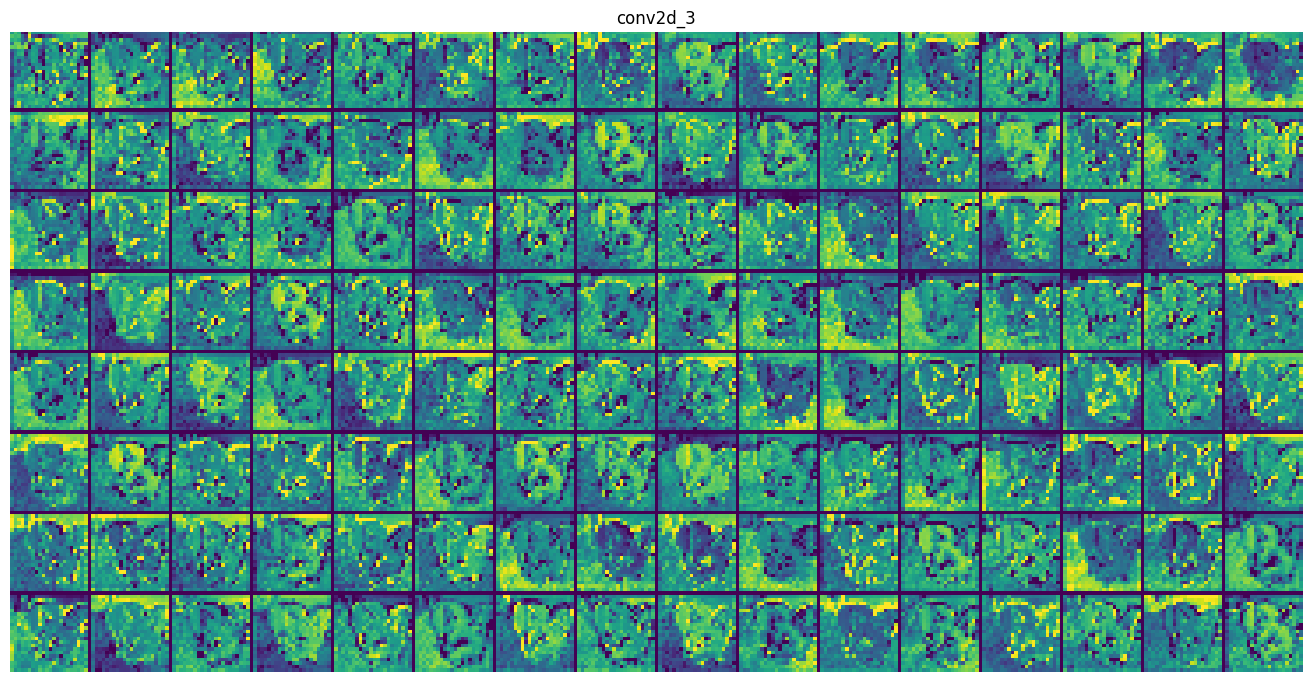

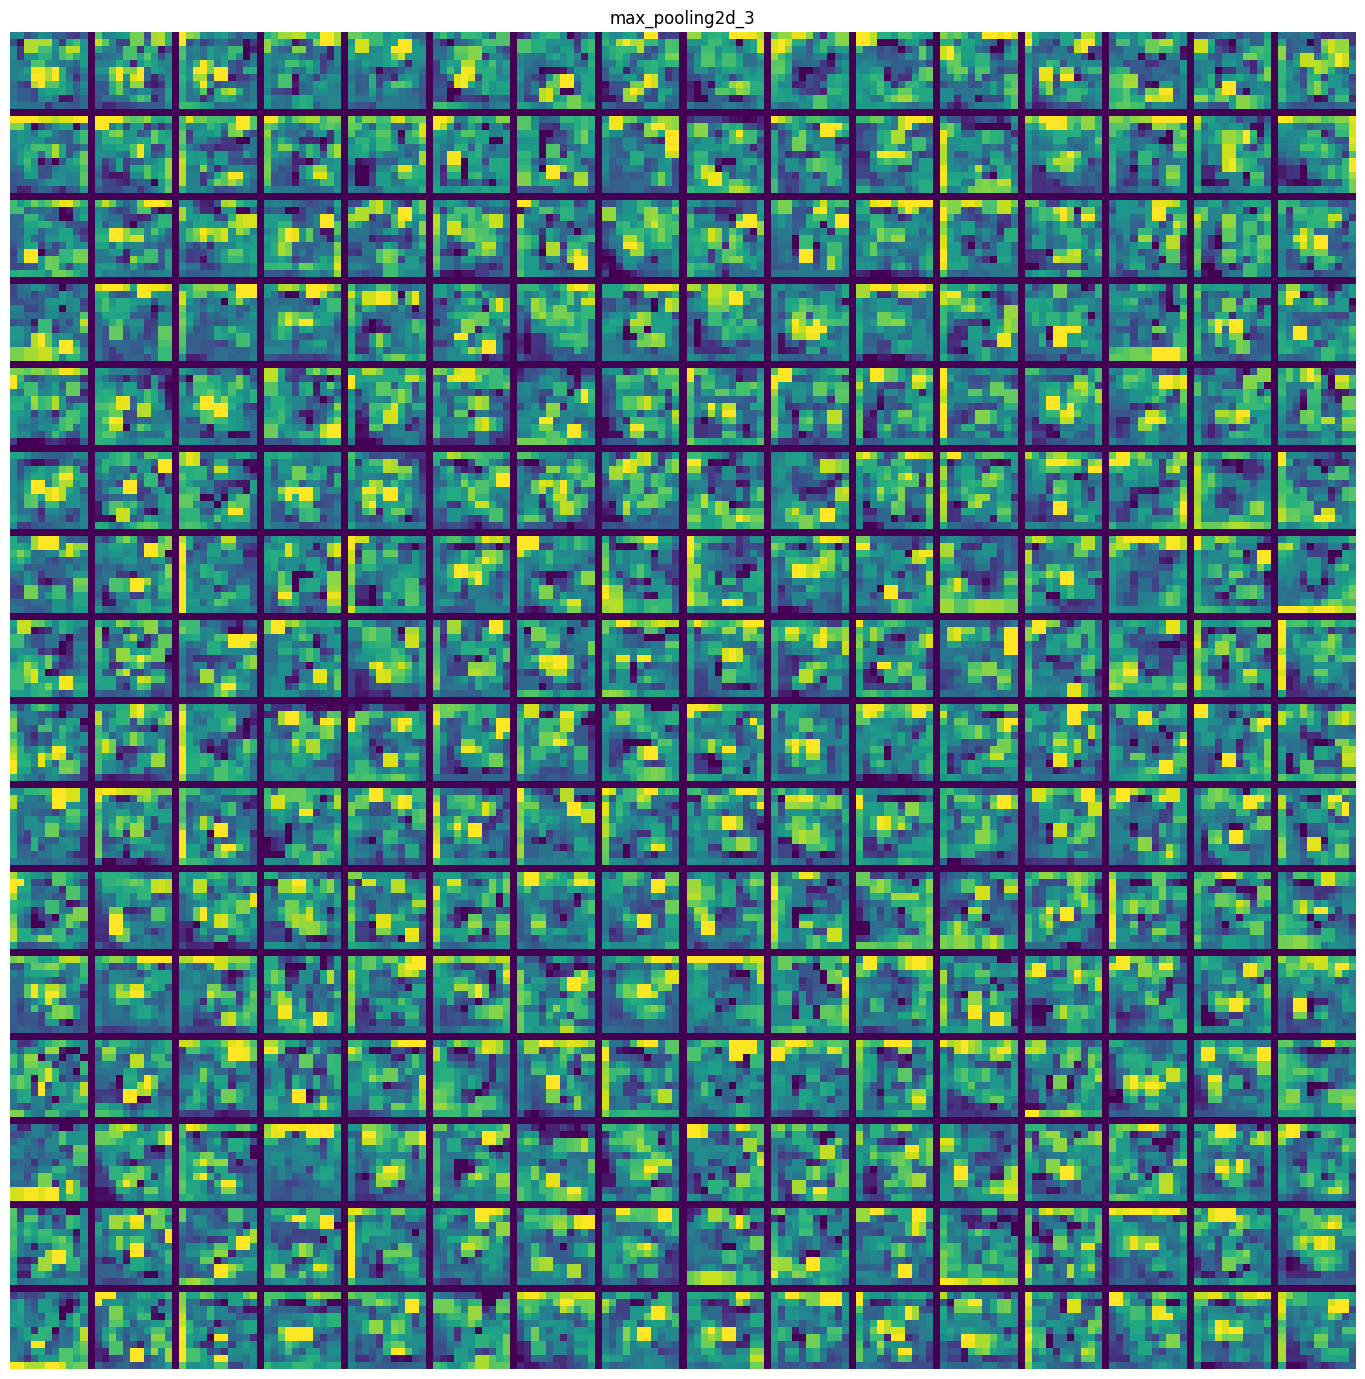

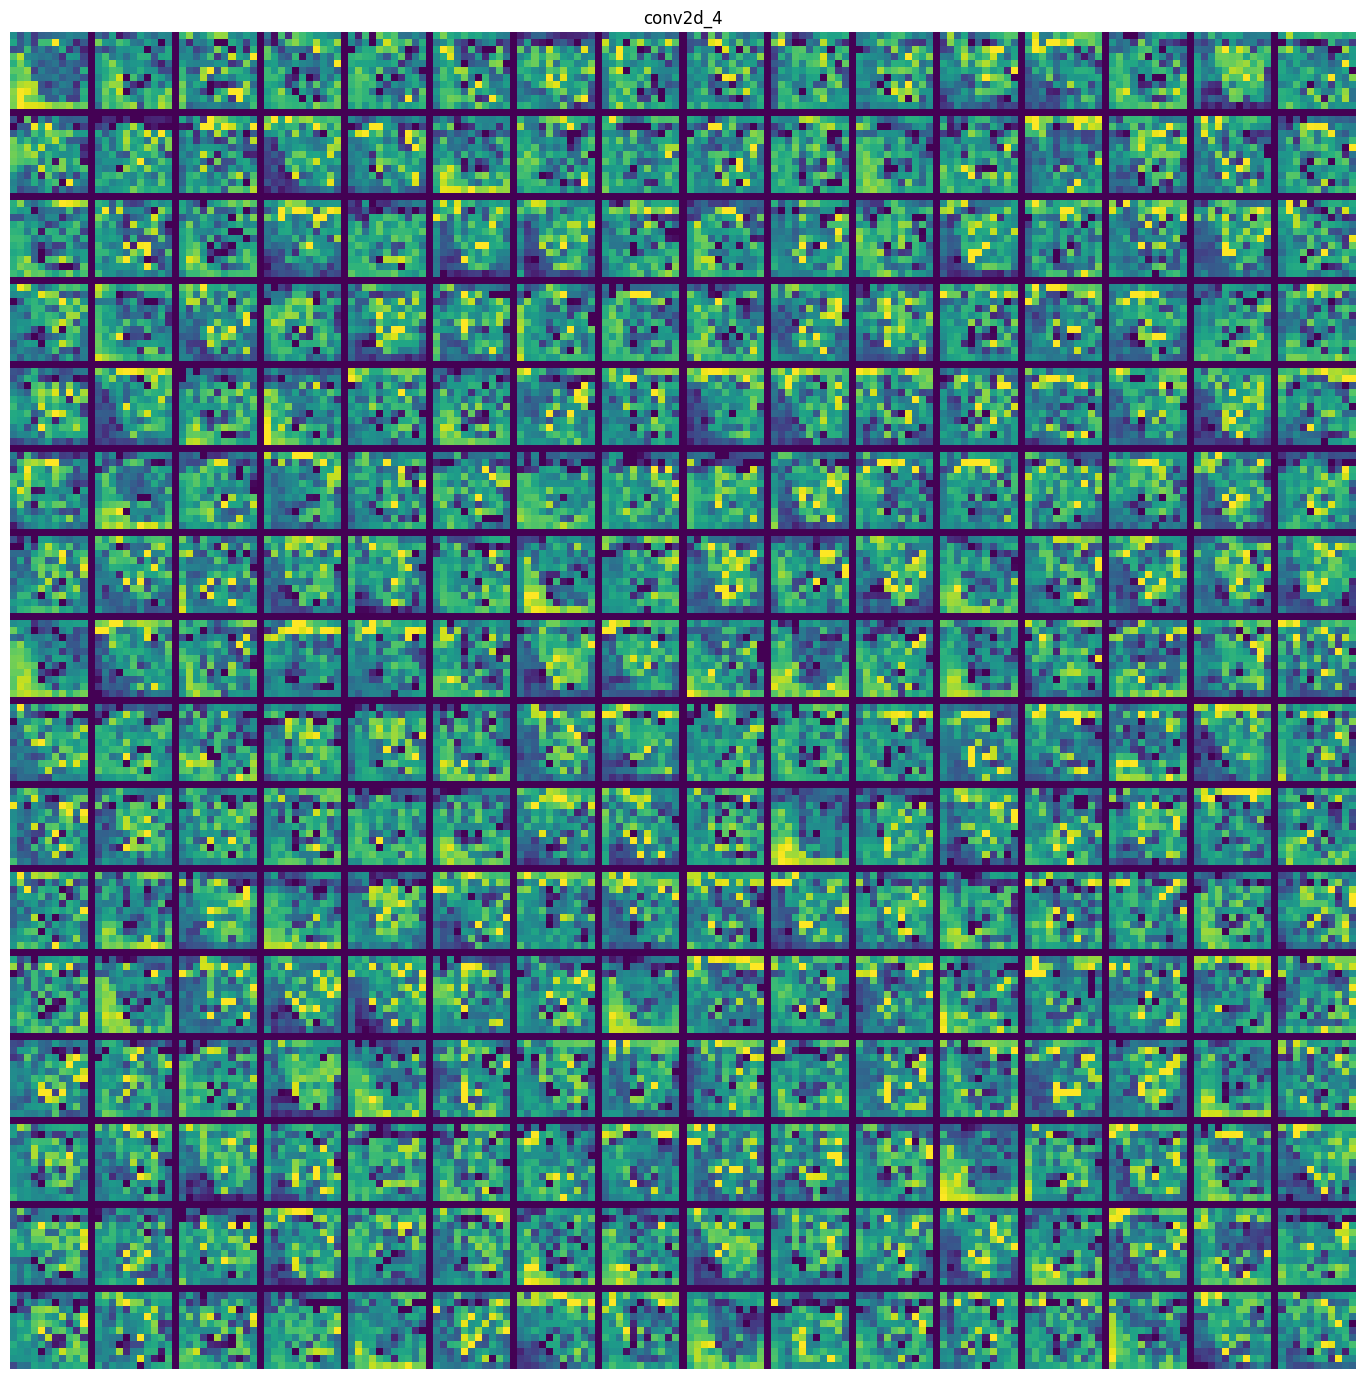

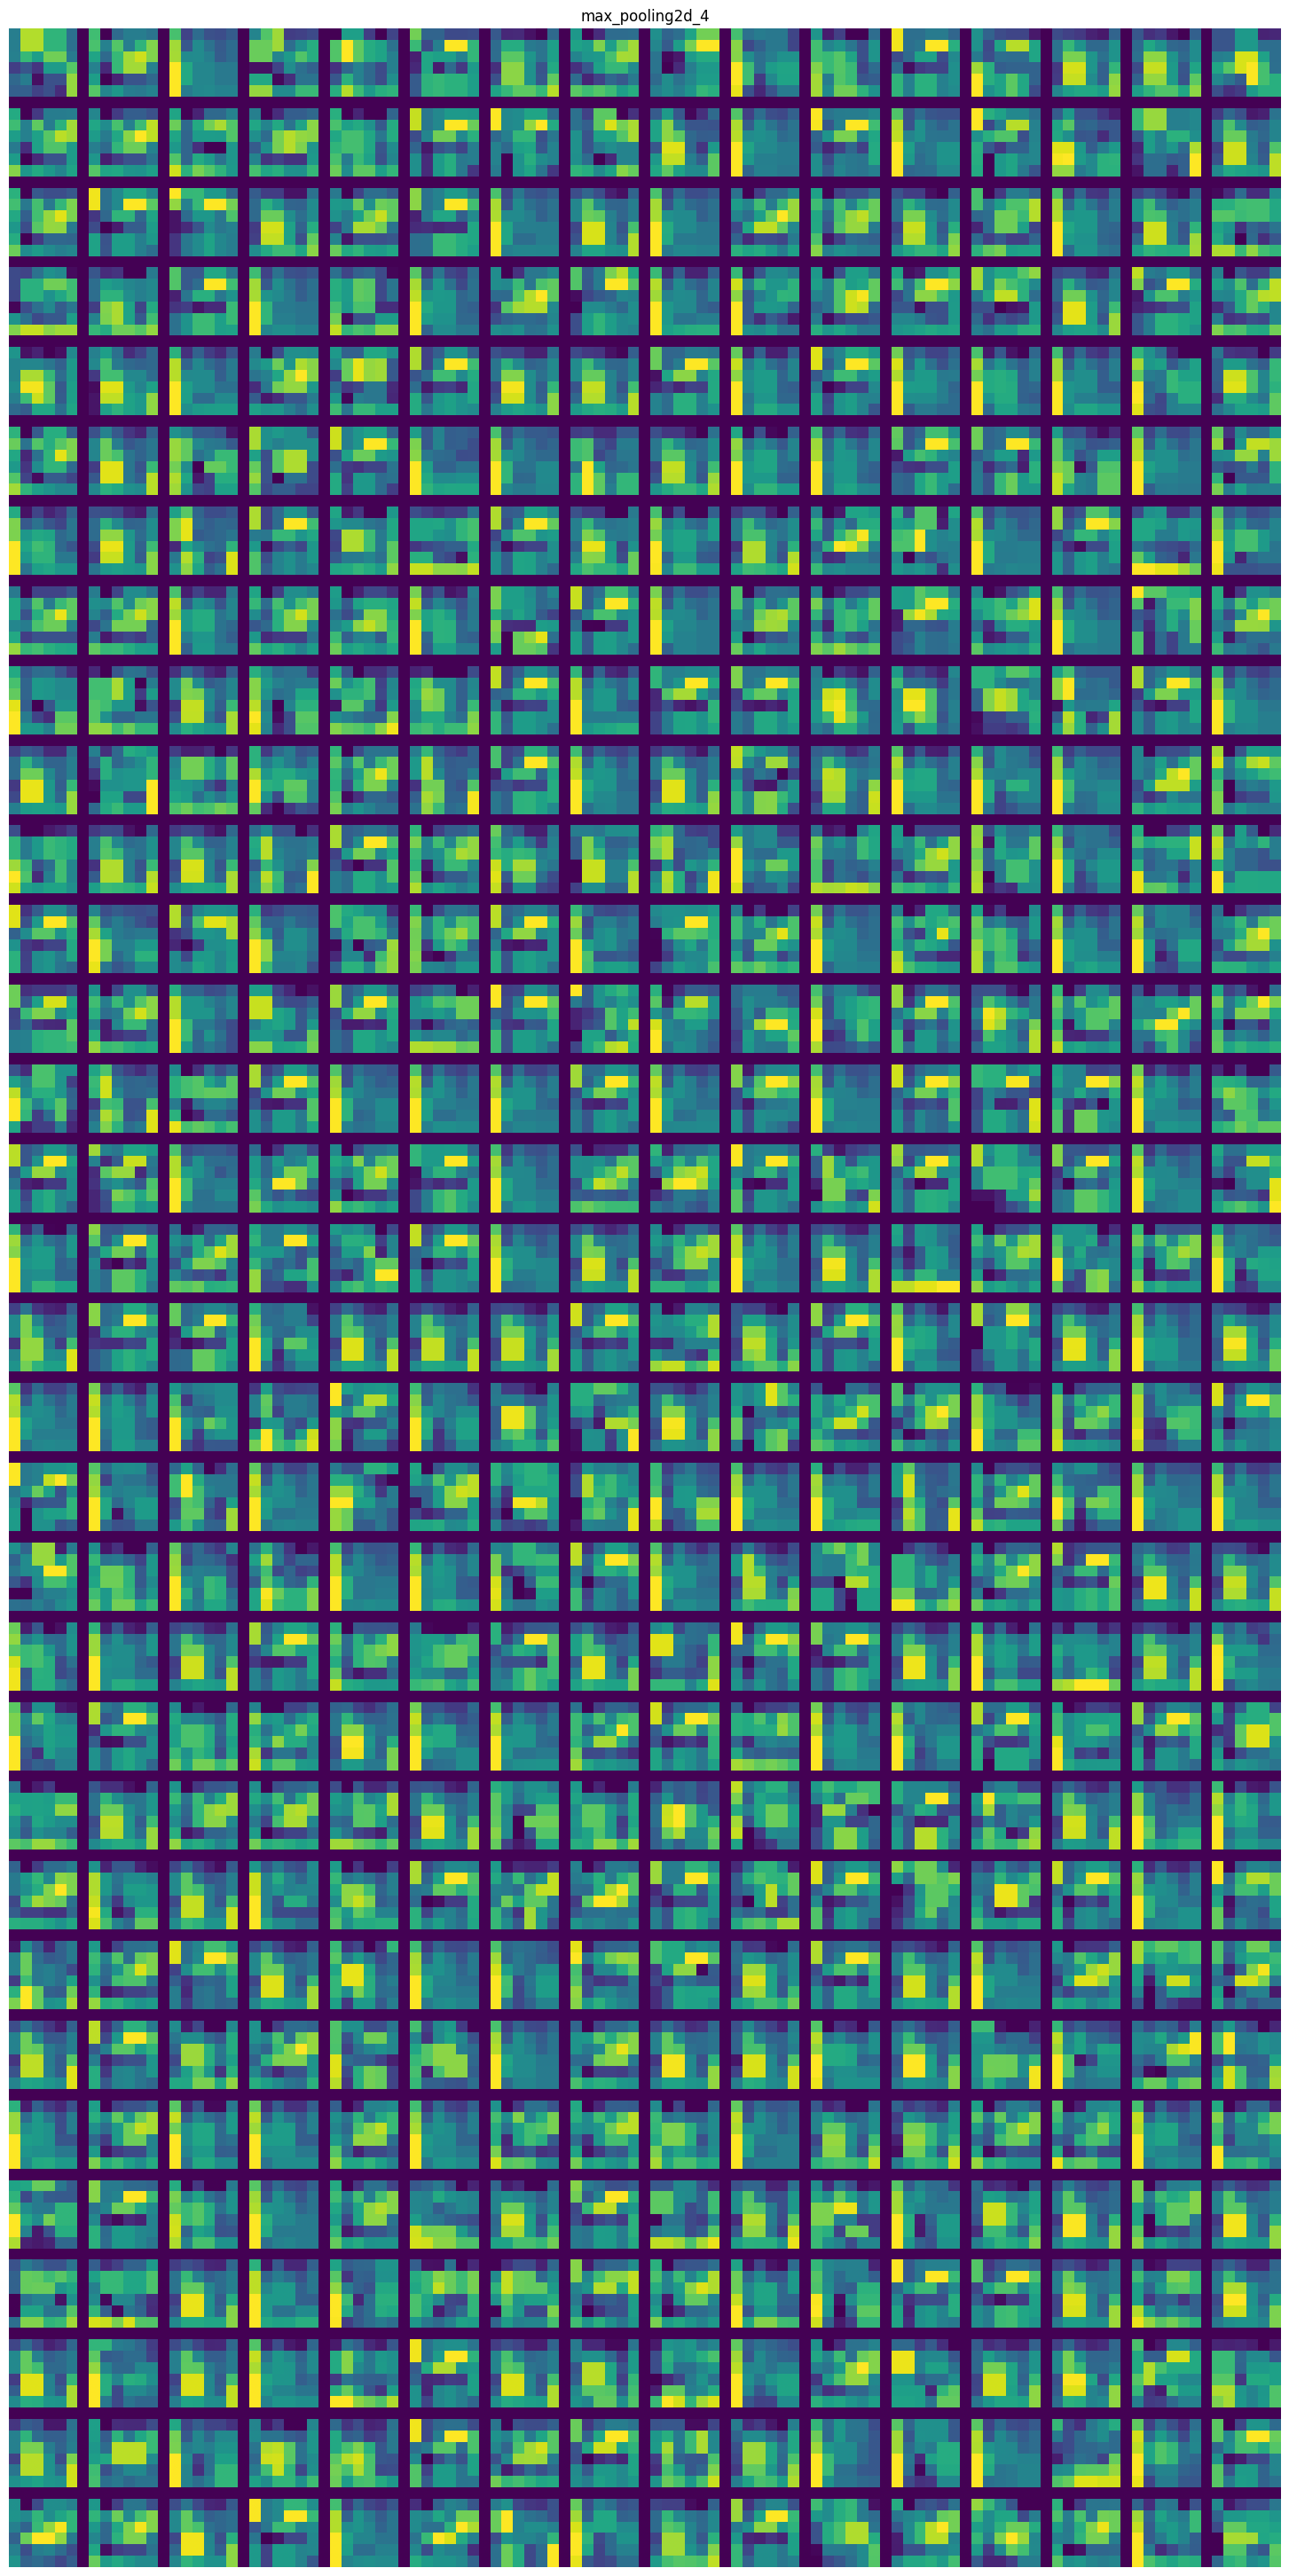

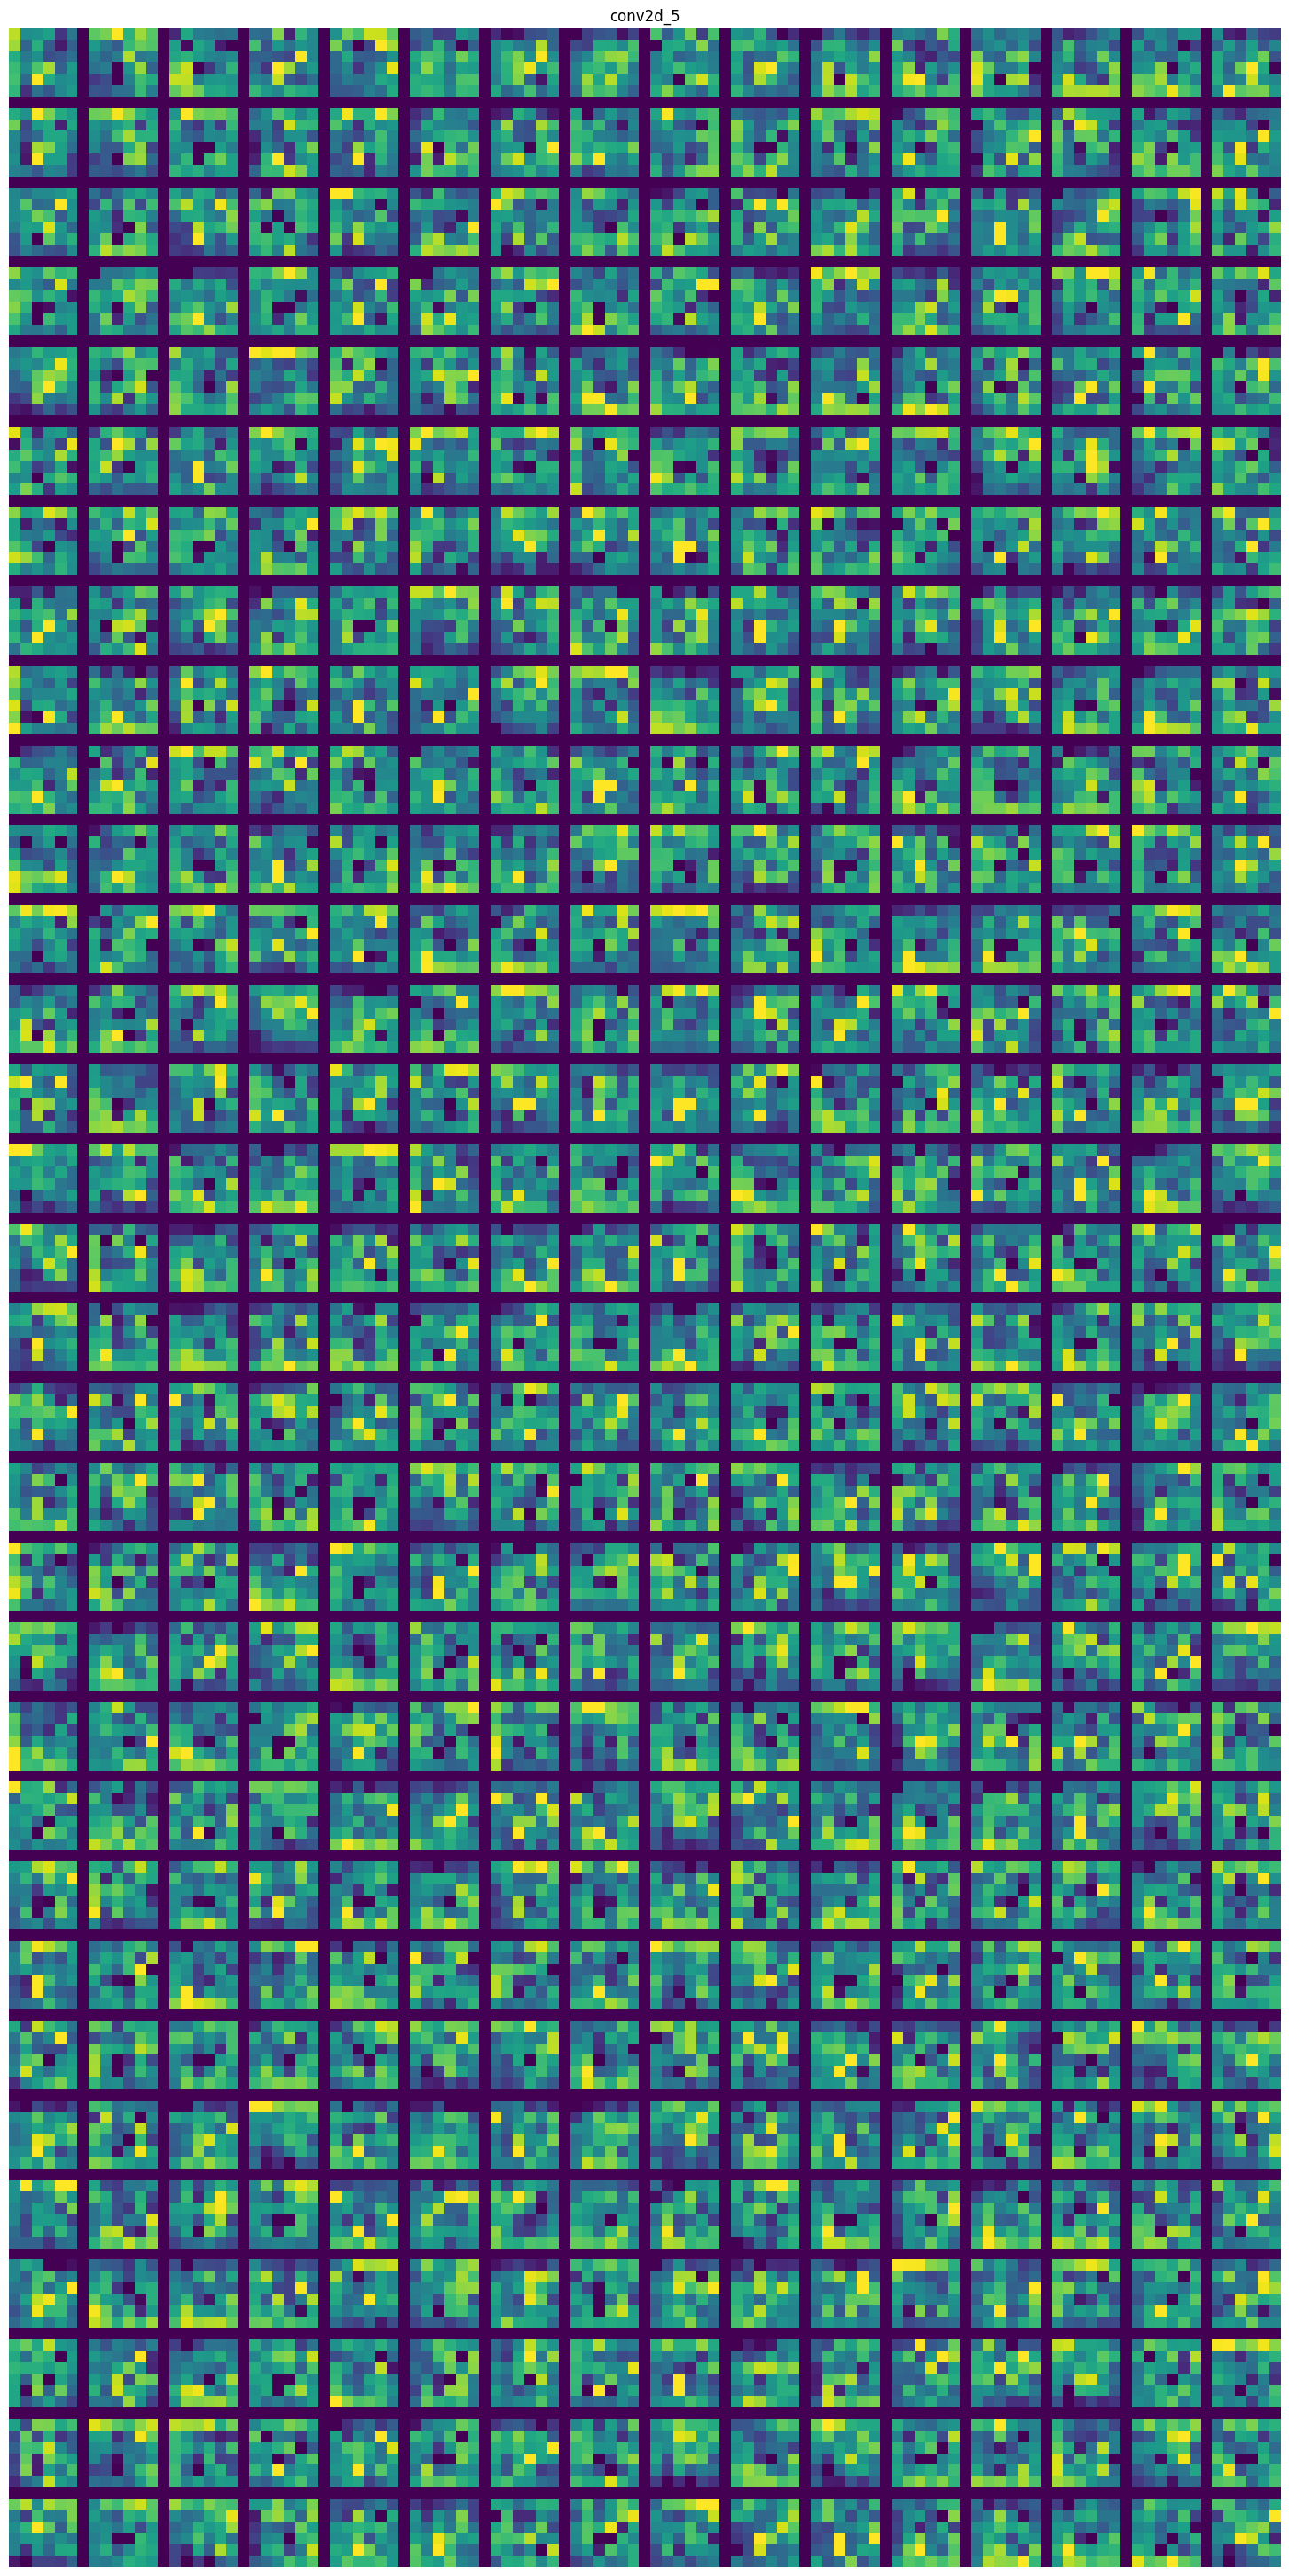

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Iterate over the activations (and the names of the corresponding layers).
  n_features = layer_activation.shape[-1] # The layer activation has shape (1, size, size, n_features).
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros(((size + 1) * n_cols - 1,images_per_row * (size + 1) - 1)) # Prepare an empty grid for displaying all the channels in this activation.
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy() # This is a single channel (or feature).

      # Normalize channel values within the [0, 255] range. Allzero channels are kept at zero.
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype("uint8")
      # Place the channel matrix in the empty grid we prepared.
      display_grid[col * (size + 1): (col + 1) * size + col,row * (size + 1) : (row + 1) * size + row] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
  scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.axis("off")
  plt.imshow(display_grid, aspect="auto", cmap="viridis")

There are a few things to note here:

 The first layer acts as a collection of various edge detectors. At that stage, the
activations retain almost all of the information present in the initial picture.

 As you go deeper, the activations become increasingly abstract and less visually
interpretable. They begin to encode higher-level concepts such as “cat ear” and
“cat eye.” Deeper presentations carry increasingly less information about the
visual contents of the image, and increasingly more information related to the
class of the image.

 The sparsity of the activations increases with the depth of the layer: in the first
layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

We have just evidenced an important universal characteristic of the representations
learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer.

The activations of higher layers carry less
and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog).

 A deep neural network effectively acts as an information distillation pipeline, with raw data going in
(in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and
useful information is magnified and refined (for example, the class of the image).

 This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were
present in it (bicycle, tree) but can’t remember the specific appearance of these
object

Your brain has learned to completely abstract its visual input—to transform it into high-level visual concepts while filtering out irrelevant visual details—making it
tremendously difficult to remember how things around you look.

[What does encoding mean and what is abstract in respect to deep learning](https://chat.openai.com/share/d80c8b8f-5647-46ff-aee1-ba9085ad965c)

# Visualizing convnet filters

[Meaning of Visualizing convent filters](https://chat.openai.com/share/a8397706-38e4-4a22-b8bb-cbc8f5cb156b)

Another easy way to inspect the filters(kernel) learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient ascent in
input space: applying gradient descent to the value of the input image of a convnet so as
to maximize the response of a specific filter, starting from a blank input image. The
resulting input image will be one that the chosen filter is maximally responsive to.

Let’s try this with the filters of the Xception model, pretrained on ImageNet. The
process is simple: we’ll build a loss function that maximizes the value of a given filter
in a given convolution layer, and then we’ll use stochastic gradient descent to adjust
the values of the input image so as to maximize this activation value

First, let’s instantiate the Xception model, loaded with weights pretrained on the
ImageNet dataset.

In [ ]:
model = keras.applications.xception.Xception(
 weights="imagenet",
 include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


We’re interested in the convolutional layers of the model—the Conv2D and SeparableConv2D layers. We’ll need to know their names so we can retrieve their outputs.
Let’s print their names, in order of depth.

You’ll notice that the SeparableConv2D layers here are all named something like
block6_sepconv1, block7_sepconv2, etc. Xception is structured into blocks, each
containing several convolutional layers.

In [ ]:
for layer in model.layers:
 if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


 Now, let’s create a second model that returns the output of a specific layer—a feature extractor model. Because our model is a Functional API model, it is inspectable: we
can query the output of one of its layers and reuse it in a new model. No need to copy
the entire Xception code.

In [ ]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output) # We use model.input and layer.output to create a model that, given an input image, returns the output of our target layer.

To use this model, simply call it on some input data (note that Xception requires
inputs to be preprocessed via the keras.applications.xception.preprocess_input
function).

In [ ]:
activation = feature_extractor(
keras.applications.xception.preprocess_input(img_tensor)
)

Let’s use our feature extractor model to define a function that returns a scalar value
quantifying how much a given input image “activates” a given filter in the layer. This is
the “loss function” that we’ll maximize during the gradient ascent process

In [ ]:
import tensorflow as tf
def compute_loss(image, filter_index):
 activation = feature_extractor(image)
 filter_activation = activation[:, 2:-2, 2:-2, filter_index] # Note that we avoid border artifacts by only involving non-border pixels in the loss; we discard the first two pixels along the sides of the activation.
 return tf.reduce_mean(filter_activation) # Return the mean of the activation values for the filter.

In [ ]:
"""
The difference between model.predict(x) and model(x)

Both y = model.predict(x) and y = model(x) (where x is an array of input data)
mean “run the model on x and retrieve the output y.” Yet they aren’t exactly the
same thing.

predict() loops over the data in batches (in fact, you can specify the batch size via
predict(x, batch_size=64)), and it extracts the NumPy value of the outputs. It’s
schematically equivalent to this:
"""
def predict(x):
 y_batches = []
 for x_batch in get_batches(x):
  y_batch = model(x).numpy()
  y_batches.append(y_batch)
 return np.concatenate(y_batches)

"""
This means that predict() calls can scale to very large arrays. Meanwhile,
model(x) happens in-memory and doesn’t scale. On the other hand, predict() is
not differentiable: you cannot retrieve its gradient if you call it in a GradientTape
scope.
You should use model(x) when you need to retrieve the gradients of the model call,
and you should use predict() if you just need the output value. In other words,
always use predict() unless you’re in the middle of writing a low-level gradient
descent loop (as we are now)
"""

Let’s set up the gradient ascent step function, using the GradientTape. Note that we’ll
use a @tf.function decorator to speed it up.

A non-obvious trick to help the gradient descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average of
the square of the values in the tensor). This ensures that the magnitude of the
updates done to the input image is always within the same range.

In [ ]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
 with tf.GradientTape() as tape:
  tape.watch(image) # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable (only Variables are automatically watched in a gradient tape).
  loss = compute_loss(image, filter_index) # Compute the loss scalar, indicating how much the current image activates the filter.
 grads = tape.gradient(loss, image) # Compute the gradients of the loss with respect to the image.
 grads = tf.math.l2_normalize(grads) # Apply the “gradient normalization trick.”
 image += learning_rate * grads # Move the image a little bit in a direction that activates our target filter more strongly.
 return image

Now we have all the pieces. Let’s put them together into a Python function that takes
as input a layer name and a filter index, and returns a tensor representing the pattern
that maximizes the activation of the specified filter

In [ ]:
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index):
 iterations = 30
 learning_rate = 10.
 image = tf.random.uniform( minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3)) # Initialize an image tensor with random values (the Xception model expects input values in the [0, 1] range, so here we pick a range centered on 0.5)
 for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)
 return image[0].numpy()

The resulting image tensor is a floating-point array of shape (200, 200, 3), with values that may not be integers within [0, 255]. Hence, we need to post-process this tensor to turn it into a displayable image. We do so with the following straightforward
utility function.

In [ ]:
def deprocess_image(image):
 image -= image.mean()
 image /= image.std()
 image *= 64
 image += 128
 image = np.clip(image, 0, 255).astype("uint8")
 image = image[25:-25, 25:-25, :]
 return image

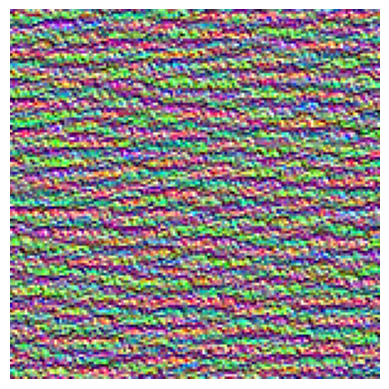

In [ ]:
 plt.axis("off")
 plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

It seems that filter 0 in layer block3_sepconv1 is responsive to a horizontal lines pattern, somewhat water-like or fur-like.


 Now the fun part: you can start visualizing every filter in the layer, and even every
filter in every layer in the model.

In [ ]:
all_images = []
for filter_index in range(64):
 print(f"Processing filter {filter_index}")
 image = deprocess_image(generate_filter_pattern(filter_index))
 all_images.append(image)

In [ ]:
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [ ]:
for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = row_start + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = column_start + cropped_height
        stitched_filters[row_start:row_end, column_start:column_end, :] = image

keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

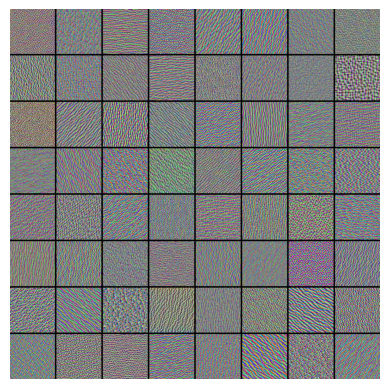

In [ ]:
from PIL import Image

# Update the file path accordingly
image_path = "/content/filters_for_layer_block3_sepconv1.png"

# Load the image using PIL
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

These filter visualizations tell you a lot about how convnet layers see
the world: each layer in a convnet learns a collection of filters such that their inputs can
be expressed as a combination of the filters.

This is similar to how the Fourier transform
decomposes signals onto a bank of cosine functions.

The filters in these convnet filter
banks get increasingly complex and refined as you go deeper in the model:

 The filters from the first layers in the model encode simple directional edges
and colors (or colored edges, in some cases).

 The filters from layers a bit further up the stack, such as block4_sepconv1,
encode simple textures made from combinations of edges and colors.

 The filters in higher layers begin to resemble textures found in natural images:
feathers, eyes, leaves, and so on.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming n is the number of filters
for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = row_start + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = column_start + cropped_height
        stitched_filters[row_start:row_end, column_start:column_end, :] = image

        # Save and display each stitched filter image
        filter_image_path = f"filter_{i}_{j}_for_layer_{layer_name}.png"
        keras.utils.save_img(filter_image_path, stitched_filters)

        # Load the saved image using PIL and display
        img = Image.open(filter_image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Visualizing heatmaps of class activation

We’ll introduce one last visualization technique—one that is useful for understanding
which parts of a given image led a convnet to its final classification decision. This is
helpful for “debugging” the decision process of a convnet, particularly in the case of a
classification mistake (a problem domain called model interpretability). It can also allow
you to locate specific objects in an image

This general category of techniques is called class activation map (CAM) visualization, and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class,
computed for every location in any input image, indicating how important each location is with respect to the class under consideration.

For instance, given an image fed
into a dogs-versus-cats convnet, CAM visualization would allow you to generate a heatmap for the class “cat,” indicating how cat-like different parts of the image are, and
also a heatmap for the class “dog,” indicating how dog-like parts of the image are

 The specific implementation we’ll use is the one described in an article titled “GradCAM: Visual Explanations from Deep Networks via Gradient-based Localization.”

Grad-CAM consists of taking the output feature map of a convolution layer, given
an input image, and weighing every channel in that feature map by the gradient of
the class with respect to the channel. Intuitively, one way to understand this trick is to
imagine that you’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,”
resulting in a spatial map of “how intensely the input image activates the class.”

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet") # Note that we include the densely connected classifier on top; in all previous cases, we discarded it.

91884032/91884032 [==============================] - 0s 0us/step


In [ ]:
img_path = keras.utils.get_file(
 fname="elephant.jpg",
 origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

733657/733657 [==============================] - 0s 0us/step


In [ ]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img) # Return a float32 NumPy array of shape (299, 299, 3).
  array = np.expand_dims(array, axis=0) # Add a dimension to transform the array into a batch of size (1, 299, 299, 3).
  array = keras.applications.xception.preprocess_input(array) # Preprocess the batch (this does channel-wise color normalization).
  return array

img_array = get_img_array(img_path, target_size=(299, 299))

You can now run the pretrained network on the image and decode its prediction vector back to a human-readable format

In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.86993945), ('n01871265', 'tusker', 0.076956384), ('n02504013', 'Indian_elephant', 0.023541829)]


The top three classes predicted for this image are as follows:

 African elephant (with 87% probability)

 Tusker (with 7% probability)

 Indian elephant (with 2% probability)

The network has recognized the image as containing an undetermined quantity of
African elephants. The entry in the prediction vector that was maximally activated is
the one corresponding to the “African elephant” class, at index 386

In [ ]:
 np.argmax(preds[0])

386

To visualize which parts of the image are the most African-elephant–like, let’s set up
the Grad-CAM process.


 First, we create a model that maps the input image to the activations of the last
convolutional layer.

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
 "avg_pool",
 "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

Second, we create a model that maps the activations of the last convolutional layer to
the final class predictions.

In [ ]:
#  Reapplying the classifier on top of the last convolutional output
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
 x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Then we compute the gradient of the top predicted class for our input image with
respect to the activations of the last convolution layer.

In [ ]:
import tensorflow as tf
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array) # Compute activations of the last conv layer and make the tape watch it
  tape.watch(last_conv_layer_output)
  # Retrieve the activation channel corresponding to the top predicted class.
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to the output feature map of the last convolutional layer.
grads = tape.gradient(top_class_channel, last_conv_layer_output)

Now we apply pooling and importance weighting to the gradient tensor to obtain our
heatmap of class activation.

In [ ]:
# This is a vector where each entry is the mean intensity of the gradient for a given channel. It quantifies the importance of each channel with regard to the top predicted class.
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]

# Multiply each channel in the output of the last convolutional layer by “how important this channel is.”
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map is our heatmap of class activation.
heatmap = np.mean(last_conv_layer_output, axis=-1)

For visualization purposes, we’ll also normalize the heatmap between 0 and 1.

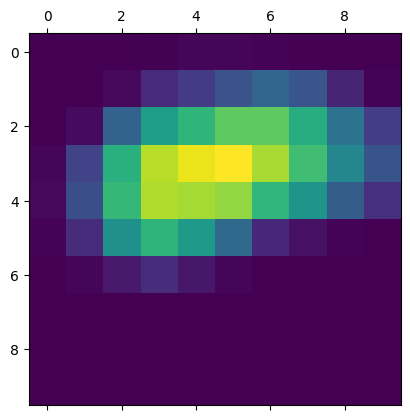

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
import matplotlib.cm as cm
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap) # Rescale the heatmap to the range 0–255.

# Use the "jet" colormap to recolorize the heatmap.
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image that contains the recolorized heatmap.
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# Superimpose the heatmap and the original image, with the heatmap at 40% opacity
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-45-ea7f57b884c7>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


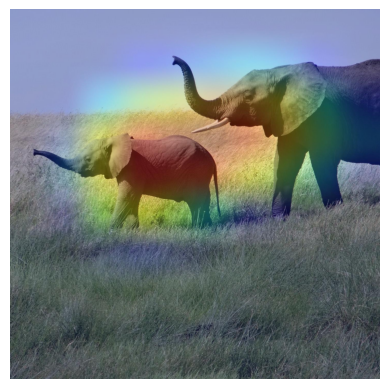

In [ ]:
from PIL import Image

# Update the file path accordingly
image_path = "/content/elephant_cam.jpg"

# Load the image using PIL
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

This visualization technique answers two important questions:

 Why did the network think this image contained an African elephant?

 Where is the African elephant located in the picture?


In particular, it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and
Indian elephants.


Summary

 There are three essential computer vision tasks you can do with deep learning:
image classification, image segmentation, and object detection.

 Following modern convnet architecture best practices will help you get the
most out of your models. Some of these best practices include using residual
connections, batch normalization, and depthwise separable convolutions.

 The representations that convnets learn are easy to inspect—convnets are the
opposite of black boxes!

 You can generate visualizations of the filters learned by your convnets, as well as
heatmaps of class activity.